In [1]:
import math
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision
from livelossplot import PlotLossesKeras
from numpy import ndarray
from PIL import Image
from sklearn.model_selection import train_test_split

# 1. Работа с данными

## 1.1 Функция, которая будет убирать "битые пиксели" с картинки, заполнять их средним значением из соседних восьми.
**Работает очень долго, но получается очень хорошо.**

In [2]:
def defective_pixels(images_data: np.ndarray) -> np.ndarray:
    """

    :param images_data: np.ndarray - массив изображений (исходный датасет)
    :return: np.ndarray[np.ndarray]

    Функция, которая убирает битые пиксели,
    заполняя их средним значением ближайших
    """

    def get_median_for_pixel(img: int, loc_row: int, loc_col: int, chanel: int):
        """
        :param img: изображение из датасета
        :param loc_row: строка пикселя
        :param loc_col: ряд пикселя
        :param chanel: канал (одно из 0, 1, 2)
        :return: медиану
        """

        return np.median(
            [
                images_data[img][loc_row - 1][loc_col + 0][chanel], images_data[img][loc_row - 1][loc_col - 1][chanel],
                images_data[img][loc_row - 1][loc_col + 1][chanel], images_data[img][loc_row + 1][loc_col + 0][chanel],
                images_data[img][loc_row + 1][loc_col - 1][chanel], images_data[img][loc_row + 1][loc_col + 1][chanel],
                images_data[img][loc_row + 0][loc_col + 1][chanel], images_data[img][loc_row + 0][loc_col - 1][chanel]
            ]
        )

    images_count = len(images_data)
    image_width = len(images_data[1])
    image_height = len(images_data[1][1])

    for im in range(images_count):
        for row in range(1, image_width - 1):
            for px in range(1, image_height - 1):
                if (
                        np.array_equal(images_data[im][row][px], np.array([1., 1., 1.])) or
                        np.array_equal(images_data[im][row][px], np.array([0., 0., 0.]))
                ):
                    images_data[im][row][px] = np.array([
                        get_median_for_pixel(im, row, px, 0),
                        get_median_for_pixel(im, row, px, 1),
                        get_median_for_pixel(im, row, px, 2)
                    ])

    return images_data[0:len(images_data), 1:-1, 1:-1, 0:3]

In [ ]:
def median_filter(img, hw=3):
    kk = hw // 2
    out_img = np.zeros((32-kk*2,32-kk*2,3))
    for row in range(kk, 32-kk):
        for col in range(kk, 32-kk):
            if(np.all(img[row, col] == 255.) or np.all(img[row, col] == 0.)):
                for clr in range(3):
                    img[row, col, clr] = out_img[row - kk, col - kk, clr] = \
                        np.median(img[row-kk:row+kk,
                                  col-kk:col+kk, clr])
            else:
                out_img[row - kk, col - kk] = img[row, col]
    return out_img

**Функции загрузки и сохранения датасетов**

In [3]:
def load_data(file_name: str) -> np.ndarray:
    """
    :param file_name: path to dataset
    :return: dataset
    """

    with open(file_name, 'rb') as input_file:
        return pickle.load(input_file)


def write_data(file_name: str, data) -> None:
    """
    :param file_name: path to dataset
    :param data: data of dataset
    :return: dataset
    """

    with open(file_name, 'wb') as output_file:
        pickle.dump(data, output_file)

In [4]:
# Грузим трейновый датасет, сохраняем лейблы

df = load_data('./DATA/data_train')
labels = df['labels']

In [5]:
# Обработка (очень долго, спускайтесь на 2 ячейки вниз)
arr = df['images'].astype(np.uint8)
# Деление на 255 - самая простая нормализация данных. Все значения конвертируются в промежуток [0;1]
arr = defective_pixels(arr / 255.)

KeyboardInterrupt: 

In [ ]:
write_data('./DATA/arr.np.ndarray', arr)

In [6]:
# Загружаем переменную arr чтобы не ждать работы функций обрабатывающих датасет

arr = load_data('./DATA/arr.np.ndarray')

### 1.2 Аугментация. Создаем последовательность преобразований фото. Используем [torchvision](https://pytorch.org/vision/stable/index.html), т.к. tensorflow предоставляет крайне скудный функционал.

### *Небольшое отступление насчет аугментаций*
*Весь смысл выполнения аугментации - преобразования данных таким образом,
чтобы итоговая модель смогла обрабатывать более нестандартные случаи, чем она увидела в трейне.
Модель должна каждый раз видеть разные фотки. Также очень важно делать так,
 чтобы аугментация происходила **случайным** образом, **во время обучения** модели.
 Такой подход позволяет практически полностью избавиться от переобучения, не искажает сути этой техники*


In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=3, scale=(.8, 1.1)),
        # Афинное преобразование - универсальный инструмент аугментации
    torchvision.transforms.RandomPerspective(.3),
    # Небольшая перспектива поможет модели отпределять кривые цифры
    torchvision.transforms.RandomAutocontrast(),
    # Следующие 3 аугметации были выбраны исходя из различия цветовых гамм на фотках.
    torchvision.transforms.ColorJitter(.5, .5, .5, .4),
    torchvision.transforms.RandomInvert(.5),
])
#  Мы также пробовали преобразовать фото в градации серого,
#  это логически должно было помочь, но этот метод показал наилучший результат.

[\*тык*](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) чтобы лицезреть аугментации

\**Для того чтобы аугментация выполнялась по ходу запроса батчей информации, создаем свой класс,
который будем передавать в качестве датасета в model.fit().
Наследуемся от [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence).**

In [8]:
    class MySequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        """
        :param x_set: последовательность картинок
        :param y_set: последовательность лейблов
        :param batch_size: размер батча
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        """
        :param idx: индекс начала батча в датасете
        :return: батч информации
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return (
            np.array([np.asarray(transform(Image.fromarray(np.uint8(x)))) / 255. for x in batch_x]),
            np.array(batch_y)
        )

**Посмотрим на обработанный датасет**

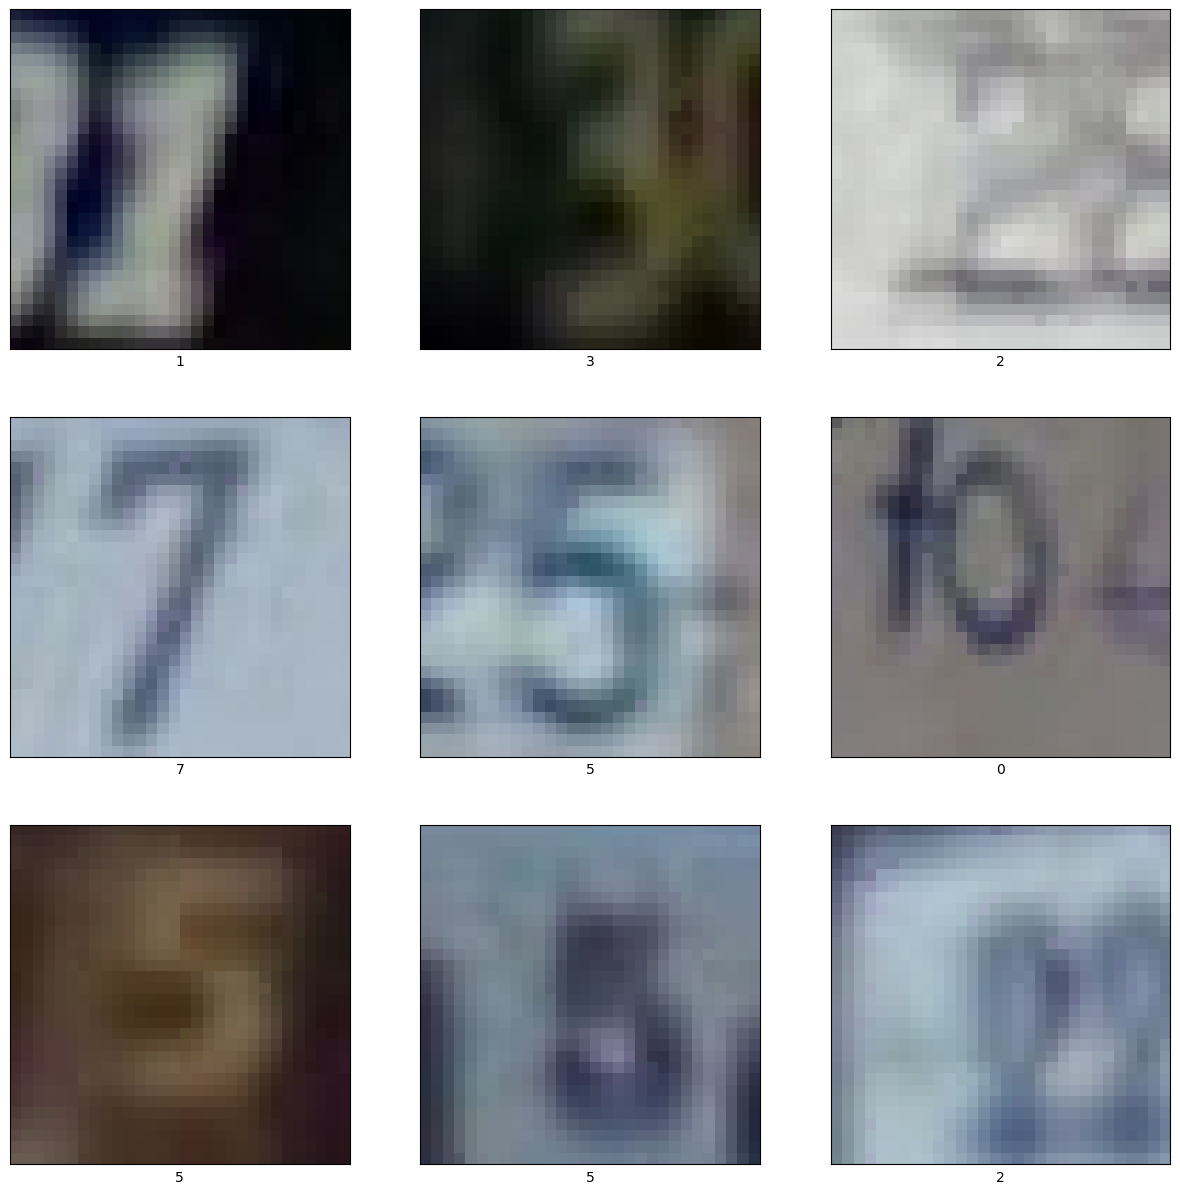

In [9]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(arr[i]))
    plt.xlabel(labels[i])

plt.show()

In [10]:
arr = np.uint8(arr * 255)

In [11]:
arr, validation_images, labels, validation_labels = train_test_split(arr, labels, test_size=0.07)

In [12]:
validation_images = validation_images / 255.  # нормализация данных

In [13]:
batch_size = 256  # Объявляем размер батча. Поставил 256 потому что могу
ds = MySequence(arr, labels, batch_size=batch_size)  # создаем Sequence


In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    validation_images,
    validation_labels
))  # валидационный датасет не аугментируется, поэтому создаем его через tf

Metal device set to: Apple M2 Pro


2023-03-28 00:44:29.338429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 00:44:29.338896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
# Ф-ция, обрабатывающая трейновый датасет урезает по пикселю с каждой стороны. Они не несут большого кол-ва информации, поэтому это не страшно.
input_shape = 30, 30, 3

In [16]:
# батчируем валидационный датасет
val_dataset = val_dataset.batch(batch_size)

# 2. Модель
#### 2.1.1 [Center Crop](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CenterCrop) обрезает 10 боковых пикселей. От нас требуется определение централной цифры (на картинке их бывает несколько). Модель может случайно вытащить фичи из соседних цифр, поэтому их можно обрезать. Широкие цифры, которым мы обрежем бока, в большинстве своем сохранят свои главные фичи.
#### 2.1.2 Модель имеет 6 сверточных блоков, соединенных скип-коннекшнами. Постепенное увеличение информации за счет увеличения каналов (32 -> 64 -> 128). Чтобы картинка не самоуничтожилась, включаем паддинг.
#### 2.1.3 После выделения признаков идет 2 полносвязных слоя. Этого достаточно для связывания признаков с выходными классами.
#### 2.1.4 Модель достаточно глубокая, требует много времени для обучения, но цель оправдывает средства.


In [17]:
input_layer = tf.keras.layers.Input(shape=input_shape)
c = tf.keras.layers.CenterCrop(28, 20)(input_layer)

# Первый блок:
b1l1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(c)
b1l2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b1l1)
b1_output = tf.keras.layers.MaxPooling2D()(b1l2)

# Второй блок:
b2l1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b1_output)
b2l2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b2l1)

# Связываем эти 2 блока
b2b1_output = tf.keras.layers.add([b2l2, b1_output])

# Третий блок:
b3l1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b2b1_output)
b3l2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b3l1)

# Связываем эти 2 блока
block_3_output = tf.keras.layers.add([b3l2, b2b1_output])

b4l1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
b4l2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b4l1)

block_4_output = tf.keras.layers.add([block_3_output, b4l2])

b5l1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
b5l2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b5l1)

block_5_output = tf.keras.layers.add([block_4_output, b5l2])

b6l1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_5_output)
b6l2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(b6l1)

block_6_output = tf.keras.layers.add([block_5_output, b6l2])

l1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_6_output)
#tmp = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(l1)
l2 = tf.keras.layers.GlobalAveragePooling2D()(l1)
l4 = tf.keras.layers.Dense(256, activation="relu")(l2)
bn = tf.keras.layers.BatchNormalization()(l4)
l5 = tf.keras.layers.Dropout(.05)(bn)
outputs = tf.keras.layers.Dense(10)(l5)

**В ходе экпериментов мы решили попробовать модель немного попроще.
Избавившись от паддинга и скип коннекшнов (больше по сути ничего не поменялось)
Мы получили огромный прирост к метрике (+0.01)**

In [18]:
modseq = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(30, 30, 3)),
    tf.keras.layers.CenterCrop(28, 20),


    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),


    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10)
])

In [19]:
model_kaggle = tf.keras.Model(input_layer, outputs, name="model")

## 2.2.1 Коллбеки-чекпоинты

#### 2.2.1.1 В tf есть возможность делать чекпоинты с помощью коллбеков (по аналогу с PlotLosses). Мы делаем 4 чекпоинта: по лоссу, аккураси, последняя модель, средняя модель.
#### 2.2.1.2 [tfa.callbacks.AverageModelCheckpoint](https://www.tensorflow.org/addons/api_docs/python/tfa/callbacks/AverageModelCheckpoint) [усредняет веса](https://towardsdatascience.com/stochastic-weight-averaging-a-new-way-to-get-state-of-the-art-results-in-deep-learning-c639ccf36a) последних выделившихся по метрикам моделей. Допустим, модель на 170-й эпохе выделяется определением кривых двоек, а на 180-й хорошо выделяет фичи 6 и 8. Усреднение весов помогает объединить эти навыки, хорошо прибавляет к итоговой метрике.

In [23]:
checkpoint_filepath = './CHECKPOINTS/modseq/acc'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

checkpoint_filepath = './CHECKPOINTS/modseq/loss'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

checkpoint_filepath = './CHECKPOINTS/modseq/freq'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_freq='epoch'
)

checkpoint_filepath = './CHECKPOINTS/modseq/avg'
model_checkpoint_callback4 = tfa.callbacks.AverageModelCheckpoint(
    filepath=checkpoint_filepath,
    update_weights=True,
    save_weights_only=False
)

## 2.2.2 [lr-scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)

**При обучении модели, ближе к концу обучения (около 200-й эпохи),
 модель находится около оптимума, но из-за большого lr перескакивает его.
 Для этого можно использовать шедулер который понижает lr по мере приближения к n-ной эпохе.
 К сожалению, этот экспириенс не оказался положительным.
 Думаю, при таких высоких метриках играет роль случайность,
 это и стало причиной того, что lr-scheduler не сыграл.**

In [24]:
lr_sheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    1e-3,
    200,
    end_learning_rate=1e-4,
    power=1.0,
    cycle=False,
    name=None
)

## 2.2.3 Оптимизатор
#### 2.2.3.1 В качестве оптимизатора мы выбрали [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), ведь он идеально подходит для нашей классификации. В параметры мы передаем [Weight-decay](https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html), эта регуляризация очень хорошо помогает бороться с переобучением. За счет более длительного обучения мы получили очень хороший результат.
#### 2.2.3.2 [MovingAverage](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/MovingAverage) - применяется к оптимизатору, позволяет работать с усреднением весов в коллбеке

In [25]:
adam = tf.keras.optimizers.Adam(decay=4e-5)
opt = tfa.optimizers.MovingAverage(adam)

In [26]:
modseq.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
modseq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_2 (CenterCrop)  (None, 28, 20, 3)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 18, 32)        896       
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 8, 32)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 8, 32)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 6, 64)         18496     
                                                      

In [27]:
model_kaggle.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model_kaggle.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 30, 3)]  0           []                               
                                                                                                  
 center_crop_1 (CenterCrop)     (None, 28, 20, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 20, 32)   896         ['center_crop_1[0][0]']          
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 20, 64)   18496       ['conv2d_4[0][0]']               
                                                                                              

In [ ]:
modseqh = modseq.fit(
    ds,
    validation_data=val_dataset,
    epochs=400,
    callbacks=[
        PlotLossesKeras(),
        model_checkpoint_callback,
        model_checkpoint_callback2,
        model_checkpoint_callback3,
        model_checkpoint_callback4
    ],
    verbose=False,
    shuffle=True
)

In [ ]:
dftest = load_data('./DATA/data_test')
arrtest = dftest['images']

In [ ]:

arrtest = np.uint8(arrtest) / 255.
arrtest = defective_pixels(arrtest)
arrtest[0]

In [ ]:
predictions = modseq.predict(arrtest)

In [ ]:
classes = np.argmax(predictions, axis=1)
classes
# 5 4 1 ... 0 9 2

In [ ]:
plt.figure(figsize=(15, 15))
for i, j in zip(range(99, 110), range(9)):
    plt.subplot(3, 3, j + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(arrtest[i]))
    plt.xlabel(classes[i])
plt.show()  # смотрим на предсказанные фоточки

#### 2.2.4 [Ансамблирование](https://en.wikipedia.org/wiki/Ensemble_learning)
**Изучив этот метод объединения моделей, метрики сильно выросли.
Эта технкиа очень схожа с п. 2.2.1.2 (усреднение весов), но она обрабатывает только выход головы (логитов).
 Комментарии излишни, прочитав статью можно все понять. Примерное использование ансамблирования в ячейках ниже**

In [ ]:
# Ансамблирование
mod1 = tf.keras.models.load_model('./CHECKPOINTS/easymodel/acc')
mod2 = tf.keras.models.load_model('./CHECKPOINTS/easymodel/freq')
mod3 = tf.keras.models.load_model('./CHECKPOINTS/easymodel/loss')
mod4 = tf.keras.models.load_model('./CHECKPOINTS/easymodel/avg')

k = np.rot90([
    i.predict(arrtest)
    for i in [mod1, mod2, mod3, mod4]
])

In [ ]:
classes = list(np.argmax(k.mean(axis=1), axis=1))
classes.reverse()

In [ ]:
classes

#### Дальше дело за малым, сохраняем решение, заливаем на кеглю

In [ ]:
with open('easyassamble.csv', 'w') as f:
    f.write('Id,Category\n')
    for i, j in enumerate(classes):
        f.write(f'{i},{j}\n')

# То, что мы изучили, но в ноутбук это не вошло
*сквозная нумерация тут заканчивается

1.  Разные виды нормализации
[Пакетная нормализация](https://machinelearningmastery.ru/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd/) не дала прироста к метрикам, работала странно.
[MinMax Scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) тоже не помог. Остановились на классической нормализации делением на 255, она самая нейтральная.


2.  Тонкая настройка, настройка головы модели.
К сожалению чекпоинт ноутбука с этим введением был утерян. Смысл ее в том, что модель делится на 2 блока - выделение признаков (сверточный блок), голова, которая связывает выделенные фичи с классами. Часто бывает так, что эти 2 "блока" обучаются неравномерно, выделение признаков делает это раньше, чем голова модели. Для этого можно обучать вторую часть отдельно. Тензорфлоу похволяет это делать, если объединить эти 2 блока в модель Sequential, в момент достаточного обучения первой части можно поставить флаг non-trainable, продолжить обучение головы.

3.  [Паддинг](https://www.geeksforgeeks.org/cnn-introduction-to-padding/)
Эксперименты с паддингом не увенчались успехом, добились +аккураси только путем уменьшения числа сверточных слоев и отказа от паддинга.

# Ресурсы:

#### Насчет улучшения и так хорошей модели:
- [Общая информация](https://www.freecodecamp.org/news/improve-image-recognition-model-accuracy-with-these-hacks/)
- [Общая информация](https://stackoverflow.com/questions/55266853/how-to-increase-model-accuracy-in-image-classification-model)
- [Общая информация](https://towardsdatascience.com/5-effective-ways-to-improve-the-accuracy-of-your-machine-learning-models-f1ea1f2b5d65)
- [Общая информация](https://www.dummies.com/article/technology/information-technology/ai/machine-learning/10-ways-improve-machine-learning-models-226836/)
- [Общая информация](https://habr.com/ru/company/otus/blog/526208/)

#### Про паддинги и receptive field
- [RF](https://theaisummer.com/receptive-field/)
- [RF](https://www.baeldung.com/cs/cnn-receptive-field-size)
- [Padding](https://www.geeksforgeeks.org/cnn-introduction-to-padding/)
- Лекции Яндекса

#### Все остальное
- Гиперссылки в markdown-ячейках